In [1]:
#Imports needed in analysis process
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [8]:
from google.colab import files


uploaded = files.upload()

Saving chess_games.csv to chess_games.csv


In [9]:
#Reading the CSV of online chess games
games = pd.read_csv("chess_games.csv")


In [10]:
#Dataset Shape
shape_before_cleaning= games.shape
print(shape_before_cleaning)

(20058, 17)


In [11]:
#Dropping game_id column
games = games.drop(['game_id'], axis = 1)
#Searching for duplicated rows and dropping them
print("No. of duplicates = ",games.duplicated().sum())
games.drop_duplicates(inplace = True)


No. of duplicates =  946


In [12]:
#Checking for null values to start cleaning data
games.isna().sum()


rated                    0
turns                    0
victory_status           0
winner                   0
time_increment           0
white_id                 0
white_rating             0
black_id                 0
black_rating             0
moves                    0
opening_code             0
opening_moves            0
opening_fullname         0
opening_shortname        0
opening_response     17956
opening_variation     5396
dtype: int64

In [13]:
#Dropping opening_response column
games = games.drop(['opening_response'], axis = 1)

In [14]:
#Filling the null values in opening_variation column with "Main Line" instead
games["opening_variation"].fillna('Main Line', inplace = True)


In [15]:
#Checking for null values after data cleaning
games.isna().sum()


rated                0
turns                0
victory_status       0
winner               0
time_increment       0
white_id             0
white_rating         0
black_id             0
black_rating         0
moves                0
opening_code         0
opening_moves        0
opening_fullname     0
opening_shortname    0
opening_variation    0
dtype: int64

In [16]:
#Creating column of rating differnce that outliers will be detected according to it.
games["rating_difference"] = abs(games['white_rating']- games['black_rating'])


In [17]:
#Function of outliers detiction
def find_outliers_IQR(df):
 q1=df.quantile(0.25)
 q3=df.quantile(0.75)
 IQR=q3-q1
 outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
 return outliers

In [18]:
outliers = find_outliers_IQR(games["rating_difference"])
print("number of outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers.max()))
print("min outlier value: "+ str(outliers.min()))
print(outliers)
#Converting outliers series to a dataframe to drop rows with the
#same id from the main dataset
outliers =outliers.reset_index()

number of outliers: 948
max outlier value: 1605
min outlier value: 532
7        695
12       555
20       582
26       746
35       856
        ... 
19749    564
19777    534
19859    571
19874    567
19921    771
Name: rating_difference, Length: 948, dtype: int64


In [19]:
#Removing outliers
games = games[~games.index.isin(outliers['index'])]


In [20]:
#Dropping rate_difference column as it will not be used anymore
games = games.drop(['rating_difference'], axis = 1)


In [29]:
column_name = 'time_increment'.strip()

In [31]:
try:
    games[['time(min)', 'increment(sec)']] = games['time_increment'].str.split('+', expand=True)
    games = games.drop(['time_increment'], axis=1)
    games['time(min)'] = games['time(min)'].astype('int64')
    games['increment(sec)'] = games['increment(sec)'].astype('int64')
except KeyError as e:
    print(f"KeyError: {e}")
    print(f"Column names in the DataFrame: {games.columns}")
except ValueError as e:
    print(f"ValueError: {e}")
    print(f"Contents of the 'time(min)' and 'increment(sec)' columns: {games['time(min)']} / {games['increment(sec)']}")



KeyError: 'time_increment'
Column names in the DataFrame: Index(['rated', 'turns', 'victory_status', 'winner', 'white_id',
       'white_rating', 'black_id', 'black_rating', 'moves', 'opening_code',
       'opening_moves', 'opening_fullname', 'opening_shortname',
       'opening_variation', 'time(min)', 'increment(sec)'],
      dtype='object')


In [33]:
#Function to categorize games according to time
def get_game_type(time):
 if time < 3:
    return 'Bullet'
 elif time < 10:
    return 'Blitz'
 elif time < 30:
    return 'Rapid'
 else:
    return 'Classic'
#Apply the function to create a new column
games['game_type'] = games['time(min)'].apply(get_game_type)


In [35]:
#Function to categorize players according to rating
def get_player_lvl(rate):
 if rate < 1200:
    return 'Beginner'
 elif rate < 1600:
    return 'Average'
 elif rate < 2000:
    return 'Advanced'
 else:
    return 'Master'
#Apply the function to create a new column
games['players_lvl'] = games['white_rating'].apply(get_player_lvl)


In [36]:
#Using moves column important data which is the first move of the game
#that defines lines of the game
games['wFirst_move'] = games['moves'].str.split(' ').str[0]
games['bFirst_move'] = games['moves'].str.split(' ').str[1]
games = games.drop(['moves'], axis = 1)

In [37]:
#Using only the opening group letter of opening_code
games['opening_code'] = games['opening_code'].str[0]


In [38]:
#Rearranging columns order
games = games[['rated', 'turns', 'victory_status', 'winner','time(min)',
 'increment(sec)','game_type','white_id', 'white_rating',
 'black_id', 'black_rating', 'wFirst_move', 'bFirst_move','players_lvl',
 'opening_code', 'opening_moves', 'opening_fullname','opening_shortname',
 'opening_variation']]


In [39]:
#Data shape before and after removing unused columns and outliers
shape_after_cleaning= games.shape
print("Data shape before cleaning: ")
print(shape_before_cleaning)
print("Data shape after cleaning: ")
print(shape_after_cleaning)


Data shape before cleaning: 
(20058, 17)
Data shape after cleaning: 
(18164, 19)


In [40]:
#First 5 rows of dataset
games.head()


,rated,turns,victory_status,winner,time(min),increment(sec),game_type,white_id,white_rating,black_id,black_rating,wFirst_move,bFirst_move,players_lvl,opening_code,opening_moves,opening_fullname,opening_shortname,opening_variation
0,False,13,Out of Time,White,15,2,Rapid,bourgris,1500,a-00,1191,d4,d5,Average,D,5,Slav Defense: Exchange Variation,Slav Defense,Exchange Variation
1,True,16,Resign,Black,5,10,Blitz,a-00,1322,skinnerua,1261,d4,Nc6,Average,B,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,Kennedy Variation
2,True,61,Mate,White,5,10,Blitz,ischia,1496,a-00,1500,e4,e5,Average,C,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,Leonardis Variation
3,True,61,Mate,White,20,0,Rapid,daniamurashov,1439,adivanov2009,1454,d4,d5,Average,D,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,Zukertort Variation
4,True,95,Mate,White,30,3,Classic,nik221107,1523,adivanov2009,1469,e4,e5,Average,C,5,Philidor Defense,Philidor Defense,Main Line


In [41]:
#Last 5 rows of dataset
games.tail()


,rated,turns,victory_status,winner,time(min),increment(sec),game_type,white_id,white_rating,black_id,black_rating,wFirst_move,bFirst_move,players_lvl,opening_code,opening_moves,opening_fullname,opening_shortname,opening_variation
20053,True,24,Resign,White,10,10,Rapid,belcolt,1691,jamboger,1220,d4,f5,Advanced,A,2,Dutch Defense,Dutch Defense,Main Line
20054,True,82,Mate,Black,10,0,Rapid,jamboger,1233,farrukhasomiddinov,1196,d4,d6,Average,A,2,Queen's Pawn,Queen's Pawn,Main Line
20055,True,35,Mate,White,10,0,Rapid,jamboger,1219,schaaksmurf3,1286,d4,d5,Average,D,3,Queen's Pawn Game: Mason Attack,Queen's Pawn Game,Mason Attack
20056,True,109,Resign,White,10,0,Rapid,marcodisogno,1360,jamboger,1227,e4,d6,Average,B,4,Pirc Defense,Pirc Defense,Main Line
20057,True,78,Mate,Black,10,0,Rapid,jamboger,1235,ffbob,1339,d4,d5,Average,D,3,Queen's Pawn Game: Mason Attack,Queen's Pawn Game,Mason Attack


In [42]:
#Random sample row of dataset
games.sample()

,rated,turns,victory_status,winner,time(min),increment(sec),game_type,white_id,white_rating,black_id,black_rating,wFirst_move,bFirst_move,players_lvl,opening_code,opening_moves,opening_fullname,opening_shortname,opening_variation
10022,False,77,Resign,White,5,5,Blitz,lebeast101,2101,shoshonte,1805,e4,e6,Master,C,13,French Defense: Rubinstein Variation | Kaspar...,French Defense,Rubinstein Variation


In [43]:
#Every column in dataset
games.columns


Index(['rated', 'turns', 'victory_status', 'winner', 'time(min)',
       'increment(sec)', 'game_type', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'wFirst_move', 'bFirst_move', 'players_lvl',
       'opening_code', 'opening_moves', 'opening_fullname',
       'opening_shortname', 'opening_variation'],
      dtype='object')

In [44]:
#Data types every column store
games.dtypes

rated                  bool
turns                 int64
victory_status       object
winner               object
time(min)             int64
increment(sec)        int64
game_type            object
white_id             object
white_rating          int64
black_id             object
black_rating          int64
wFirst_move          object
bFirst_move          object
players_lvl          object
opening_code         object
opening_moves         int64
opening_fullname     object
opening_shortname    object
opening_variation    object
dtype: object

In [45]:
#Statistics of every numerical column
games.describe()


,turns,time(min),increment(sec),white_rating,black_rating,opening_moves
count,18164.000000,18164.000000,18164.000000,18164.000000,18164.000000,18164.000000
mean,61.077626,13.644572,4.996366,1592.574158,1587.207058,4.813202
std,33.595276,16.584605,13.511090,278.745004,280.473208,2.776098
min,1.000000,0.000000,0.000000,784.000000,791.000000,1.000000
25%,37.000000,10.000000,0.000000,1403.000000,1398.000000,3.000000
50%,56.000000,10.000000,0.000000,1566.000000,1562.000000,4.000000
75%,79.000000,15.000000,7.000000,1783.000000,1776.000000,6.000000
max,349.000000,180.000000,180.000000,2622.000000,2588.000000,28.000000


In [46]:
games.corr()

<ipython-input-46-e97691e0a1c9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  games.corr()


,rated,turns,time(min),increment(sec),white_rating,black_rating,opening_moves
rated,1.000000,0.087339,-0.104289,-0.085124,0.040817,0.047852,-0.000735
turns,0.087339,1.000000,-0.054193,-0.058613,0.149336,0.163766,0.048759
time(min),-0.104289,-0.054193,1.000000,0.466762,-0.073640,-0.078387,-0.027538
increment(sec),-0.085124,-0.058613,0.466762,1.000000,-0.035373,-0.036759,-0.016743
white_rating,0.040817,0.149336,-0.073640,-0.035373,1.000000,0.762632,0.281151
black_rating,0.047852,0.163766,-0.078387,-0.036759,0.762632,1.000000,0.272682
opening_moves,-0.000735,0.048759,-0.027538,-0.016743,0.281151,0.272682,1.000000


In [47]:
#Number of rated and casual games
games['rated'].value_counts()


True     14935
False     3229
Name: rated, dtype: int64

In [48]:
#How a game can end
games['victory_status'].unique()


array(['Out of Time', 'Resign', 'Mate', 'Draw'], dtype=object)

In [49]:
#Number of games won by white or black or ended as a draw
games['winner'].value_counts()


White    9058
Black    8247
Draw      859
Name: winner, dtype: int64

In [50]:
#Most game type played
games['game_type'].value_counts()


Rapid      13333
Blitz       3609
Classic     1113
Bullet       109
Name: game_type, dtype: int64

In [51]:
#How many opening codes in dataset
games['opening_code'].nunique()


5

In [52]:
#How many openings used in all 18164 games
games['opening_fullname'].nunique()


1447

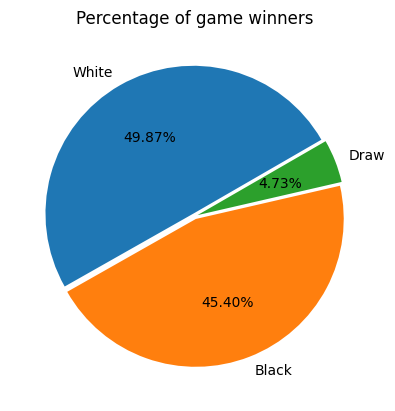

In [53]:
labels = ['White', 'Black', 'Draw']
plt.pie(games['winner'].value_counts(), labels = labels,
 autopct='%1.2f%%', explode = [0.02,0.02,0.02], startangle =30)
plt.title('Percentage of game winners')
plt.show()

White    9058
Black    8247
Draw      859
Name: winner, dtype: int64


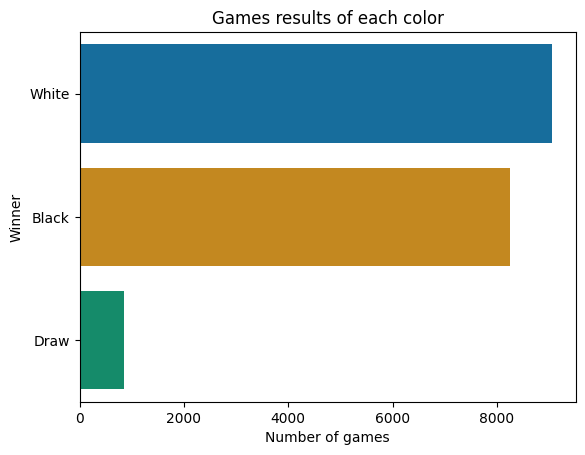

In [54]:
print(games['winner'].value_counts())
sns.countplot(data = games, y = 'winner', palette = 'colorblind')
plt.ylabel('Winner')
plt.xlabel('Number of games')
plt.title('Games results of each color')
plt.show()

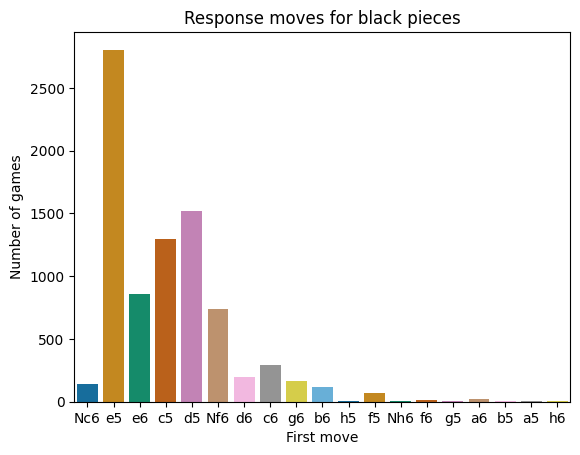

In [55]:
black_winner_games = games[games['winner'] == 'Black']
sns.countplot(x = 'bFirst_move', data = black_winner_games, palette = 'colorblind')
plt.xlabel('First move')
plt.ylabel('Number of games')
plt.title('Response moves for black pieces')
plt.show()

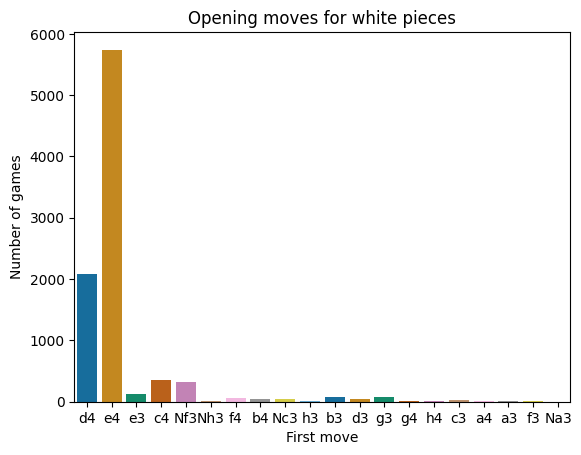

In [56]:
white_winner_games = games[games['winner'] == 'White']
sns.countplot(x = 'wFirst_move', data = white_winner_games, palette = 'colorblind')
plt.xlabel('First move')
plt.ylabel('Number of games')
plt.title('Opening moves for white pieces')
plt.show()

In [60]:
#Adding New column with boolean value if the higher rated player won or not
def condition(row):
 if (row['black_rating'] > row ['white_rating'] and row['winner'] == 'Black') or (row['black_rating'] < row ['white_rating'] and row['winner'] == 'White'):
    return True
 else:
    return False
games['higher_rated_win'] = games.apply(lambda row : condition(row), axis=1)


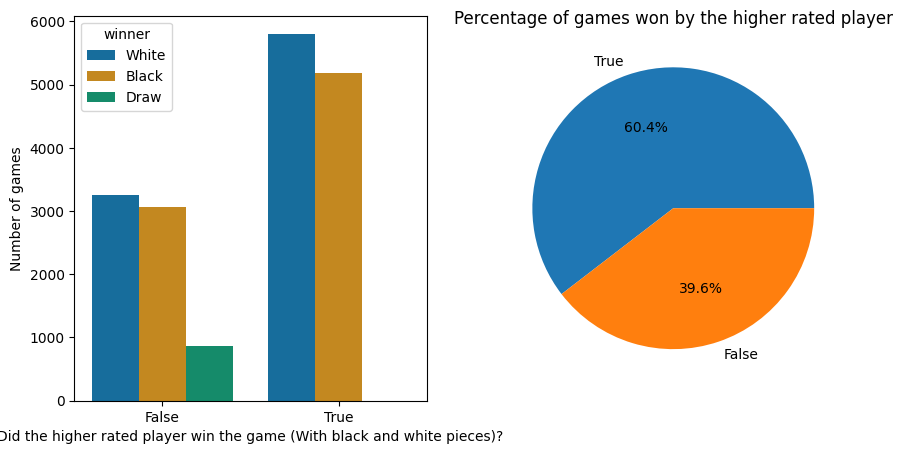

In [62]:
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=games, x='higher_rated_win', hue='winner', palette='colorblind', ax=ax[0])
ax[0].set_xlabel('Did the higher rated player win the game (With black and white pieces)?')
ax[0].set_ylabel('Number of games')
ax[1].pie(games['higher_rated_win'].value_counts(), labels=['True', 'False'], autopct='%1.1f%%')
ax[1].set_title('Percentage of games won by the higher rated player')
plt.show()

In [64]:
#Adding New column with the id of the winning player of the game
def condition2(row):
 if row['winner'] == 'Black':
    return row['black_id']
 elif row['winner'] == 'White':
    return row['white_id']
 else:
    return 'No winner'
games['winner_id'] = games.apply(lambda row : condition2(row), axis=1)


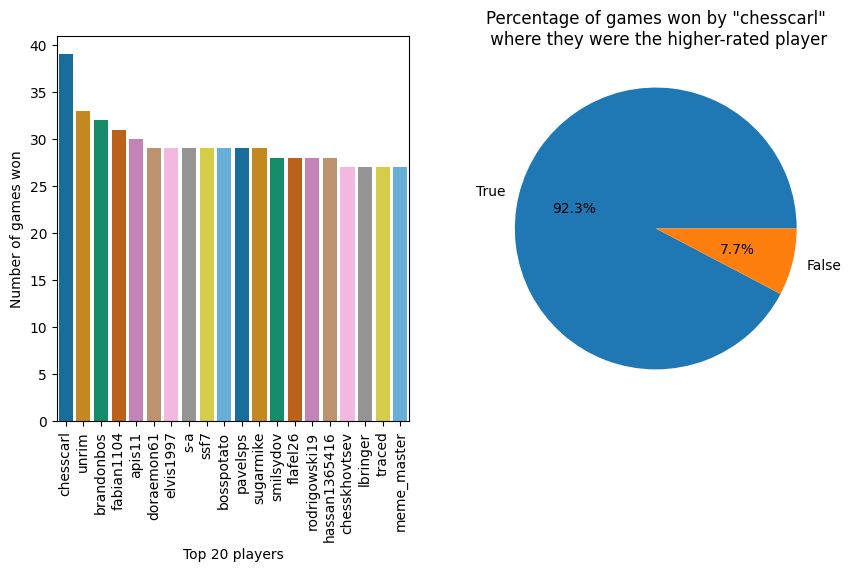

In [66]:
top_20 = games['winner_id'].value_counts().head(21)[1:]
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
g = sns.barplot(x=top_20.index, y=top_20.values, palette='colorblind', ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
ax[0].set_xlabel('Top 20 players')
ax[0].set_ylabel('Number of games won')
top_player_games = games[games['winner_id'] == top_20.index[0]]
ax[1].pie(top_player_games['higher_rated_win'].value_counts(), labels=['True', 'False'], autopct='%1.1f%%')
ax[1].set_title('Percentage of games won by "' + str(top_20.index[0]) + '"\n where they were the higher-rated player')

# Show the plots.
plt.show()

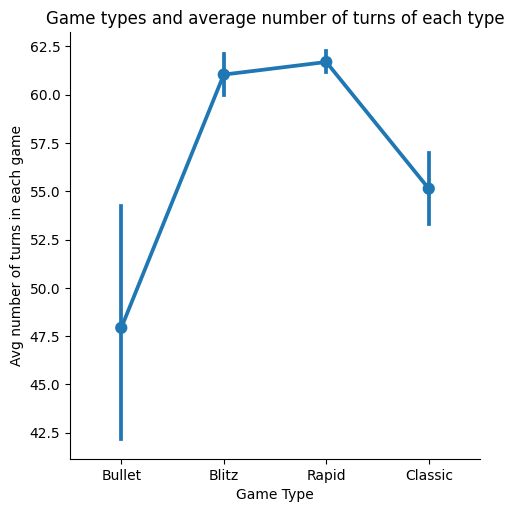

In [67]:
sorted_games = games.sort_values(by=['time(min)', 'increment(sec)'])
sns.catplot(x = 'game_type',y = 'turns', data = sorted_games, kind = 'point')
plt.xlabel('Game Type')
plt.ylabel('Avg number of turns in each game')
plt.title('Game types and average number of turns of each type')
plt.show()

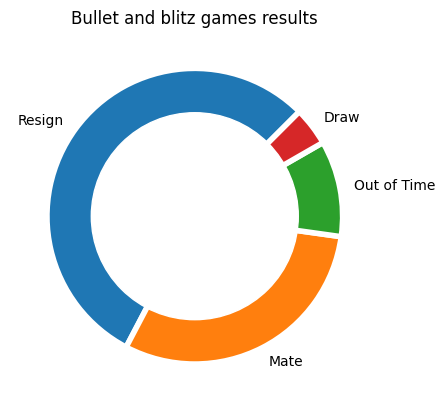

In [69]:
bb_games = games.query('game_type == "Blitz" | game_type == "Bullet"')
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(
    bb_games['victory_status'].value_counts(),
    labels=['Resign', 'Mate', 'Out of Time', 'Draw'],
    wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
    startangle=45,
)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Bullet and blitz games results')
plt.show()

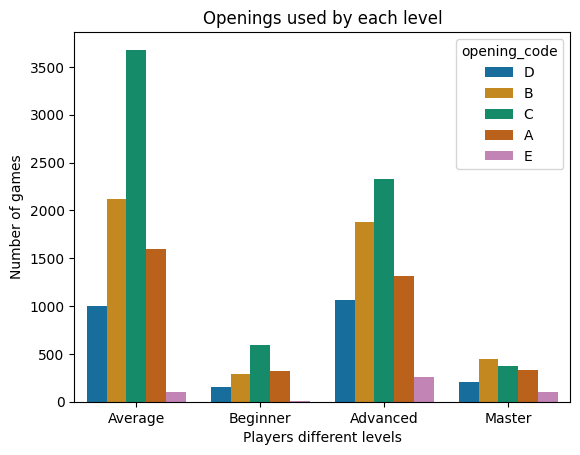

In [70]:
sns.countplot(data=games, hue='opening_code', x='players_lvl', palette='colorblind')
plt.xlabel("Players different levels")
plt.ylabel("Number of games")
plt.title("Openings used by each level")
plt.show()